In [2]:
import sys
sys.path.append('../')

import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd
import jsonpickle

from particle_filter import particlefilter
from pmcmc import particlemcmc
from math_utils import nbinom_logpmf,norm_logpmf

In [3]:
'''Import data'''

data = pd.read_csv('../data_sets/ou_SIRH_data_nbinom.csv').to_numpy()
state = pd.read_csv('../data_sets/ou_SIRH_state_nbinom.csv').to_numpy()
betas = pd.read_csv('../data_sets/ou_SIRH_betas_nbinom.csv').to_numpy()

In [4]:
def SIRH_model(particles,observations,t,dt,model_params,rng):
    '''Definition of SEIR model as described in Calvetti's paper. Difference 
    is the use of Tau leaping to introduce stochasticity into the system and continuous log-normal OU process definition for beta.'''
    hosp,R,mu,sig = model_params

    lam = 1/50
    D = 1/7
    gamma = 1/100
    L = 0.#1/100

    A = np.exp(-lam * dt)
    M = mu * (np.exp(-lam * dt) - 1)
    C = sig * np.sqrt(1 - np.exp(-2 * lam * dt))

    '''Tau leaping. Non estimated parameters are hard coded. '''

    for index in range(particles.shape[0]):

        new_S = rng.poisson((L * particles[index,3,t]) * dt)
        new_I = rng.poisson((particles[index,4,t] * (particles[index,0,t] * particles[index,1,t])/np.sum(particles[index,:,t])) * dt)
        new_IH = rng.poisson((D * gamma * particles[index,1,t]) * dt)
        new_HR = rng.poisson((hosp * particles[index,2,t]) * dt)
        new_IR = rng.poisson((D *(1 - gamma) * particles[index,1,t]) * dt)

        particles[index,0,t] = np.maximum(0.,particles[index,0,t] + new_S - new_I)
        particles[index,1,t] = np.maximum(0.,particles[index,1,t] + new_I - (new_IH + new_IR))
        particles[index,2,t] = np.maximum(0.,particles[index,2,t] + new_IH - new_HR)
        particles[index,3,t] = np.maximum(0.,particles[index,3,t] + new_HR + new_IR - new_S)

        particles[index,4,t] = np.exp(A * np.log(particles[index,4,t]) - M + C * rng.standard_normal())

        observations[index,0,t] = particles[index,2,t]

    return particles,observations

def SIRH_Obs(data_point, particle_observations, model_params):
    r = 1/model_params[1]
    weights = nbinom_logpmf(x = data_point,p = r/(r + particle_observations[:,0] + 0.005),n = np.array([r]))
    return weights


In [5]:
'''True parameter values'''
rng = np.random.default_rng(0)

'''unpickle parameter sets'''
with open("../param_sets/SIRH_OU_model_params.json", "r+") as f:
    SIRS_model_json = f.read()
    SIRS_model_params = jsonpickle.decode(SIRS_model_json)

gamma = SIRS_model_params['gamma']
R = SIRS_model_params['R']
D = SIRS_model_params['D']
hosp = SIRS_model_params['hosp']

with open("../param_sets/SIRH_OU_process_params.json", "r+") as f:
    OU_process_json = f.read()
    SIRS_OU_process_params = jsonpickle.decode(OU_process_json)

mean_ou = SIRS_OU_process_params['mean_ou']
sig = SIRS_OU_process_params['sig']

T = 250
dt = 0.1
t_vec = np.arange(0,T,dt)

def SIRH_init(num_particles, model_dim, rng):
    particles_0 = np.zeros((num_particles,model_dim))
    particles_0[:,0] = 100_000
    I_init = rng.integers(50,200,size = (num_particles))
    particles_0[:,0] -= I_init
    particles_0[:,1] = I_init
    particles_0[:,4] = rng.uniform(0.01,0.2, size = (num_particles,))
    

    return particles_0

pf_params = {'num_particles':10_000, 
                      'dt':dt,
                      'model':SIRH_model,
                      'observation_model':SIRH_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRH_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= (hosp,1/R,mean_ou,sig),
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

13.457349799980875


 Log Likelihood : -672.6131898658399
Root Mean Squared Error for the Data 85.69215727315037


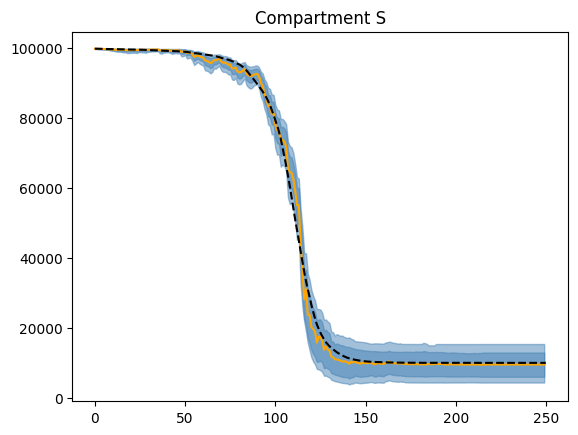

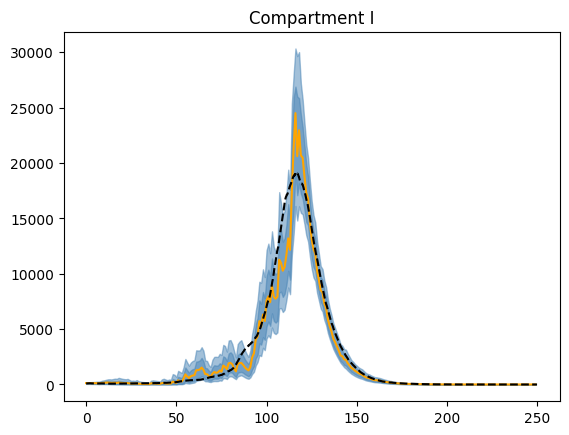

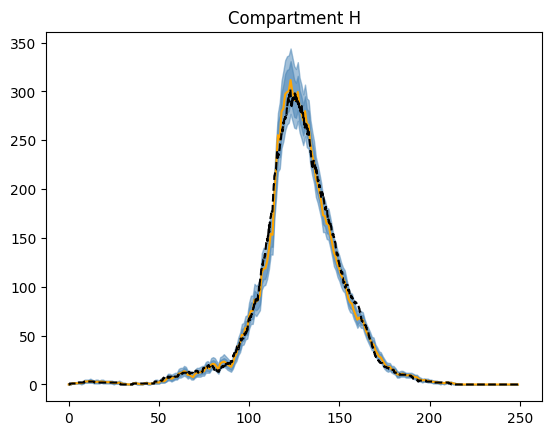

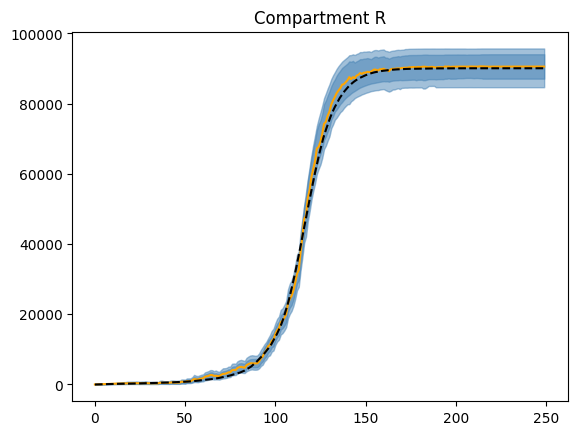

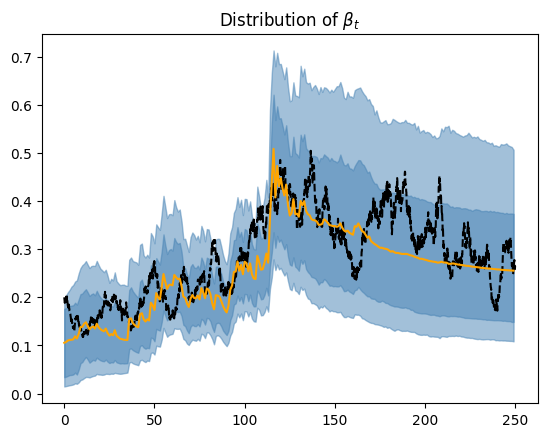

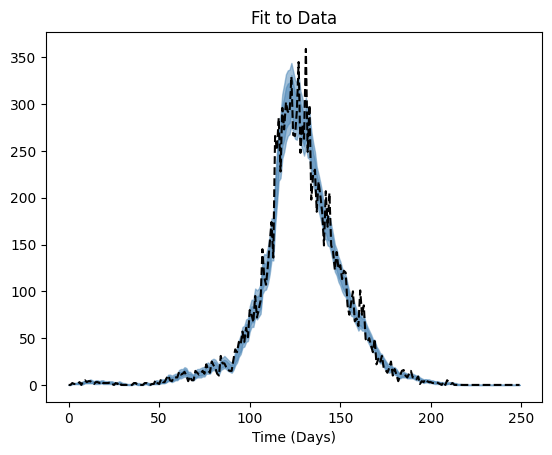

In [6]:
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")

print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

labels = ['S','I','H','R']
for i in range(4):
    plt.title(f'Compartment {labels[i]}')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.plot(np.average(output['particle_distribution'][:,i,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    plt.show()

plt.title('Distribution of $\\beta_t$')
plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.plot(np.average(output['particle_distribution'][:,4,:],weights = np.exp(output['log_weights']),axis = 0),color = 'orange')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

In [7]:
pmcmc_rng = np.random.default_rng(10)

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)

def sirh_prior(theta):
    return uniform_numba_logpdf(theta[0],min_val= 0.,max_val= 1.) + \
    uniform_numba_logpdf(theta[1],min_val = 1/1000.,max_val = 1/5.) + \
    uniform_numba_logpdf(theta[2],min_val = -2.,max_val = -0.7) + \
    uniform_numba_logpdf(theta[3],min_val = 0.,max_val=1.)


'''estimated params hosp,R,mean_ou,sig'''

pmcmc_params = {'iterations':50_000,
                'init_params':np.array([0.1,0.1,-1.,0.01]),
                'prior':sirh_prior,
                'init_cov':  np.diag([0.001,0.001,0.001,0.001]),
                'burn_in':1_000}

pf_params = {'num_particles':500, 
                      'dt':1.,
                      'model':SIRH_model,
                      'observation_model':SIRH_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRH_init
                      }

t = perf_counter()
pmcmc_output = particlemcmc(
                  data = data,
                  pmcmc_params=pmcmc_params,
                  pf_params=pf_params,
                  adaptive=True,
                  rng = rng,
                  req_jit=True
                  )
print(perf_counter() - t)

iteration: 10| Acceptance rate: 0.1| Log-Likelihood: -716.1816757764478| Proposal [ 0.06118807  0.13556654 -1.02059656  0.02429888]
iteration: 20| Acceptance rate: 0.15| Log-Likelihood: -699.9495520495224| Proposal [ 0.07302691  0.05042493 -1.07374208  0.05086046]
iteration: 30| Acceptance rate: 0.13333333333333333| Log-Likelihood: -682.2690838412445| Proposal [ 0.07170481  0.03175916 -1.1263089   0.04809939]
iteration: 40| Acceptance rate: 0.1| Log-Likelihood: -682.2690838412445| Proposal [ 0.07170481  0.03175916 -1.1263089   0.04809939]
iteration: 50| Acceptance rate: 0.1| Log-Likelihood: -670.3783900874865| Proposal [ 0.06376904  0.01757957 -1.06901892  0.11597561]
iteration: 60| Acceptance rate: 0.08333333333333333| Log-Likelihood: -670.3783900874865| Proposal [ 0.06376904  0.01757957 -1.06901892  0.11597561]
iteration: 70| Acceptance rate: 0.07142857142857142| Log-Likelihood: -670.3783900874865| Proposal [ 0.06376904  0.01757957 -1.06901892  0.11597561]
iteration: 80| Acceptance r

-665.5821466513611
The Maximum Likelihood Estimate is [ 0.06996987  0.01889818 -0.86036608  0.35916711] w/ LL of -665.5821466513611


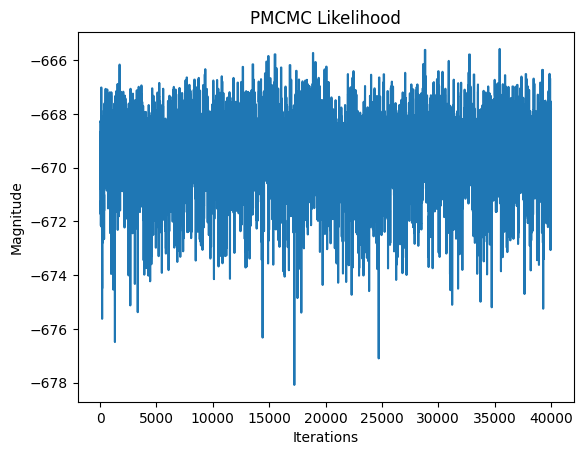

In [15]:
burn_in = 10_000

MLE = np.argmax(pmcmc_output['Log Likelihood'])

print(pmcmc_output['Log Likelihood'][MLE])

print(f"The Maximum Likelihood Estimate is {pmcmc_output['accepted_params'][:,MLE]} w/ LL of {pmcmc_output['Log Likelihood'][MLE]}")

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(pmcmc_output['Log Likelihood'][burn_in:])

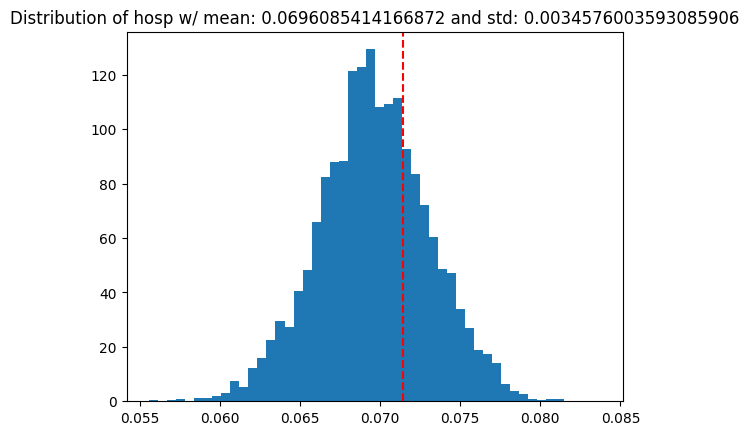

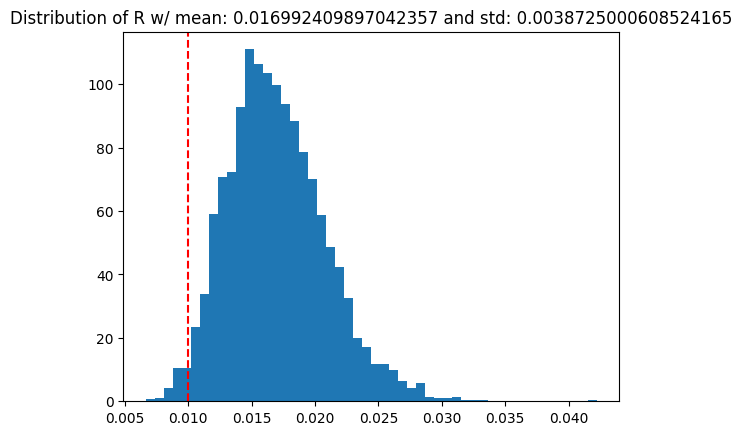

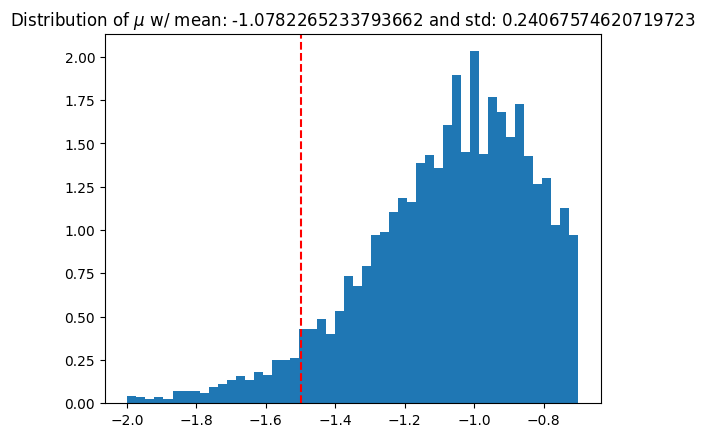

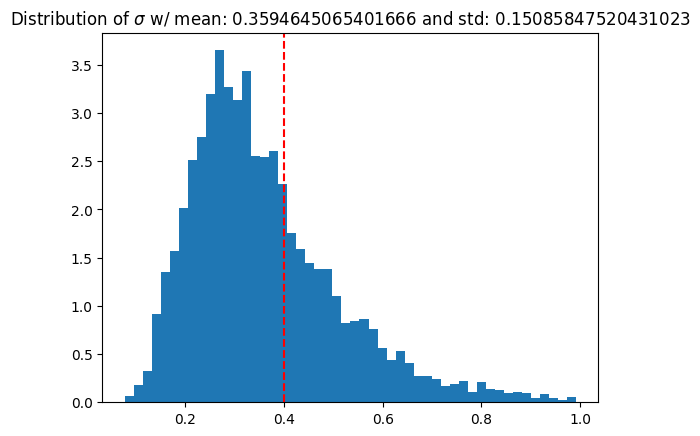

In [19]:
plt.title(f"Distribution of hosp w/ mean: {np.mean(pmcmc_output['accepted_params'][0,burn_in:])} and std: {np.std(pmcmc_output['accepted_params'][0,burn_in:])}")
plt.hist(pmcmc_output['accepted_params'][0,burn_in:],density=True,bins = 50)
plt.axvline(x=hosp, color='r', linestyle='--') 
plt.show()

plt.title(f"Distribution of R w/ mean: {np.mean((pmcmc_output['accepted_params'][1,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][1,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][1,burn_in:]),density=True,bins = 50)
plt.axvline(x=1/R, color='r', linestyle='--') 
plt.show()

plt.title(f"Distribution of $\\mu$ w/ mean: {np.mean((pmcmc_output['accepted_params'][2,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][2,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][2,burn_in:]),density=True,bins = 50)
plt.axvline(x=mean_ou, color='r', linestyle='--') 
plt.show()

plt.title(f"Distribution of $\\sigma$ w/ mean: {np.mean((pmcmc_output['accepted_params'][3,burn_in:]))} and std: {np.std((pmcmc_output['accepted_params'][3,burn_in:]))}")
plt.hist((pmcmc_output['accepted_params'][3,burn_in:]),density=True,bins = 50)
plt.axvline(x=sig, color='r', linestyle='--') 
plt.show()


In [17]:
par = np.mean((pmcmc_output['accepted_params'][:,burn_in:]),axis = 1)

pf_params = {'num_particles':10_000, 
                      'dt':dt,
                      'model':SIRH_model,
                      'observation_model':SIRH_Obs,
                      'model_dim':5,
                      'particle_initializer':SIRH_init,
                      }

from time import perf_counter

t = perf_counter()
output = particlefilter(data = data,
        model_params= par,
        pf_params = pf_params,
        rng = rng,
        req_jit=True
        )

print(perf_counter() - t)

8.95076199999312


 Log Likelihood : -670.3528201295305
Root Mean Squared Error for the Data 85.6898113878243


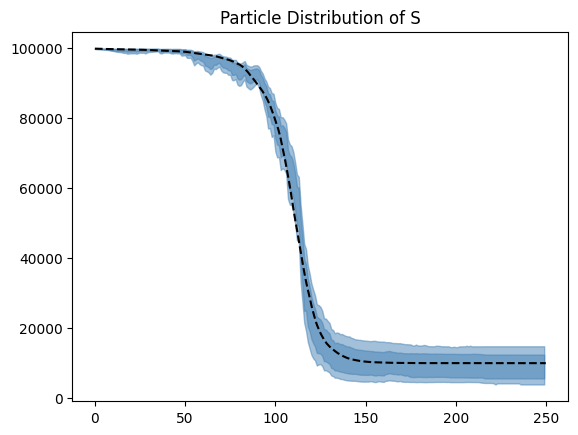

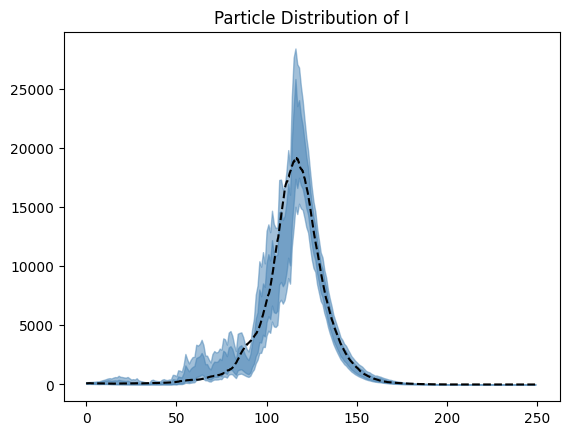

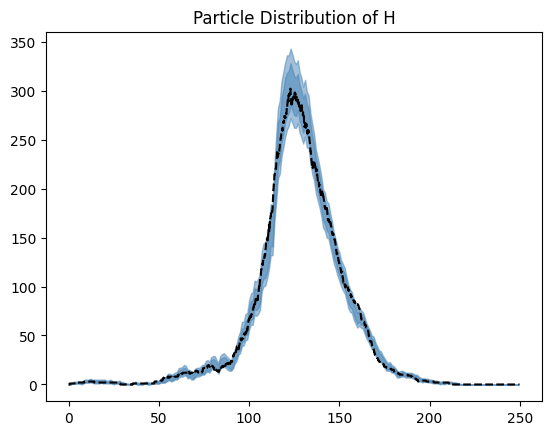

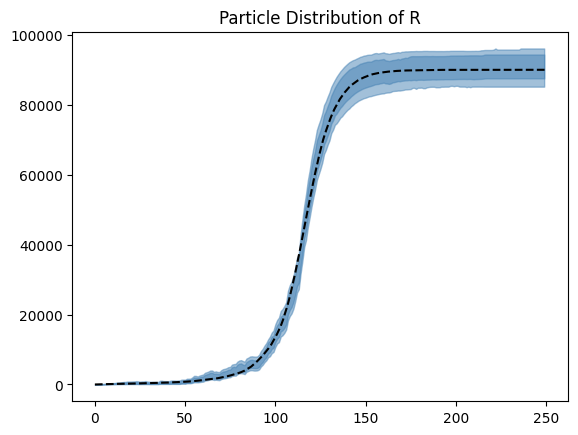

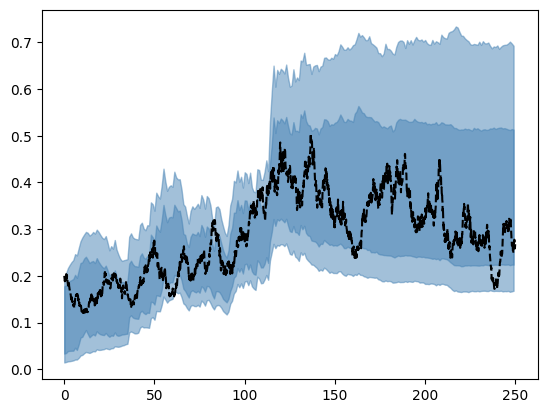

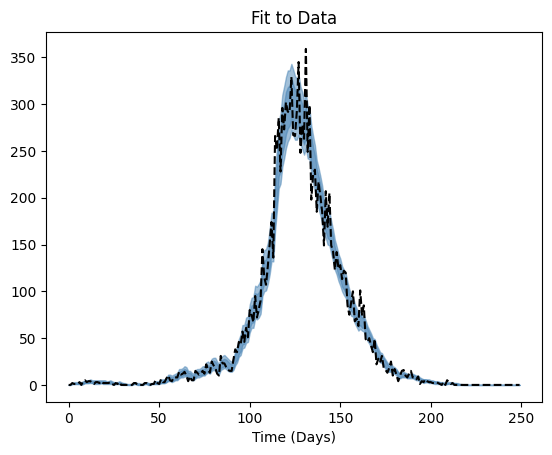

In [11]:
'''Plots using the Expectation of the parameters and running the filter. '''
print(f" Log Likelihood : {np.sum(output['Log_likelihood'])}")
print(f"Root Mean Squared Error for the Data {np.sqrt(np.mean((data - np.mean(output['particle_observations'][:,0,:]))**2))}")

dt = pf_params['dt']
Labels = ['S','I','H','R']
for i in range(4):
    plt.title(f"Particle Distribution of {Labels[i]}")
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,i,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,i,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
    plt.plot(t_vec,state[i,:].T,'--',color = 'black')
    plt.show()

plt.plot(t_vec,betas,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,2.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_distribution'][:,4,:].T,12.5,axis = 1),np.percentile(output['particle_distribution'][:,4,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

plt.title("Fit to Data")
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data.T,'--',color = 'black')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,2.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,97.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(output['particle_observations'][:,0,:].T,12.5,axis = 1),np.percentile(output['particle_observations'][:,0,:].T,87.5,axis = 1),alpha = 0.5,color = 'steelblue')
plt.show()

In [12]:
np.savez('../pmcmc_output/SIRH_pmcmc_output.npz',
accepted_params = pmcmc_output['accepted_params'],
log_likelihood=pmcmc_output['Log Likelihood'],
MLE_particle_dist = pmcmc_output['MLE_particle_dist'],
MLE_particle_observations = pmcmc_output['MLE_particle_observations'])